In [1]:
from skimage import data, io, filters
from skimage.transform import rescale
from skimage.color import rgb2gray
from skimage.feature import hog 
from skimage.transform import resize

import random
import csv
from os import listdir
from os.path import isfile, join

from sklearn.ensemble import  RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB,GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score

In [2]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpi
%matplotlib inline

In [3]:
import glob
import tqdm
from copy import copy

In [4]:
speakers1 = ['A', 'B', 'C', 'D', 'E']
speakers2 = ['user_3', 'user_4', 'user_5', 'user_6', 'user_7', 'user_9', 'user_10']
letters = ['a', 'c', 'h', 'v', 'y']
alphabet = {}
from string import ascii_lowercase
for c in ascii_lowercase:
    alphabet[c] = c;
del alphabet['j']
del alphabet['z']
alphabet = sorted(list(alphabet))

In [6]:
#return hog of a particular image vector
def convertToGrayToHOG(imgVector):
    rgbImage = rgb2gray(imgVector)
    return hog(rgbImage, block_norm='L2-Hys')

#takes returns cropped image 
def crop(img,x1,x2,y1,y2):
    crp = img[y1 : y2, x1 : x2]
    crp = resize(crp, ((128,128)), mode='constant')#resize
    return crp

In [7]:
def collectImages_for_dataset1(letter, freq):
    speakers = ['A', 'B', 'C', 'D', 'E']
    path = 'dataset1/'
    data = []
    for s in speakers:
        image_path = path + s + '/' + letter + '/'
        names = glob.glob(image_path + "*.*")
        for i in range(0, len(names), freq):
            name = names[i]
            image = cv2.imread(name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = convert_size_for_dataset1(image)
            #plt.imshow(clear_background_rough(image))
            data.append(image)
    return data

In [8]:
def convert_size_for_dataset1(image):
    h = image.shape[0]
    w = image.shape[1]
    if h > w:
        if (w/h > 0.8):
            k = int((h - w) / 2)
            image = image[k:-k-1, :]
        else:
            image = image[int(0.1*h): -int(0.1*h)-1, :]
    if h < w:
        if (h/w > 0.8):
            k = int((w - h) / 2)
            image = image[:, k:-k-1]
        else:
            image = image[:, int(0.1*h): -int(0.1*h)-1]
    return cv2.resize(image, (128, 128))

# ML functions

In [9]:
def fit_pca(X, n_comp):
    pca = PCA(n_components=n_comp)
    return pca.fit(X)

def fit_svm(X, y, C, gamma):
    svm = SVC(C = C, random_state=241, gamma=gamma, probability=True)
    return svm.fit(X, y)

def fit_pca_svm(X, y, n_comp=100, C = 2, gamma=0.0001):
    pca = fit_pca(X, n_comp=n_comp)
    smv = fit_svm(pca.transform(X), y, C = C, gamma=gamma)
    return (pca, svm)

def fit_get_score_pca_svm(X, y, X_test, y_test, n_comp, C, gamma):
    pca = fit_pca(X, n_comp=n_comp)
    X_tr = pca.transform(X)
    X_test_tr = pca.transform(X_test)
    print(pca.explained_variance_ratio_[:min(n_comp, 20)])
    
    svm = fit_svm(X_tr, y, C = C, gamma = gamma)
    print(svm)
    print('support vectors count:', len(svm.support_))
    print('train score:', accuracy_score(y, svm.predict(X_tr)))
    print('test score:', accuracy_score(y_test, svm.predict(X_test_tr)))
    
    return (pca, svm)

def get_score_pca_svm(pca, svm, X, y):
    X_tr = pca.transform(X)
    y_pred = svm.predict(X_tr)
    return accuracy_score(y, y_pred)

# Binary classification, hand / not hand

In [113]:
def collect_binary_from_datasets(letters):
    X = []
    Y = []
    cur = 0
    for letter in letters:
        data1 = collectImages_for_dataset1(letter, 20)
        for Im in data1:
            X.append(convertToGrayToHOG(Im))
            Y.append(1)
    imageset, boundbox, X2, Y2 = load_binary_data(speakers2)
    X += X2
    Y += Y2
    X3, Y3 = load_real_data('../ilya/Our_hands/')
    X += X3
    Y += Y3
    X = np.array(X)
    Y = np.array(Y)
    #print(Y.shape)
    dumpimages(X, Y, 'ishand')
    #print(X.shape, Y.shape, X2.shape, Y2.shape)
    return imageset, X, Y

random_order = np.random.permutation(X.shape[0])
    x_shuffle = []
    y_shuffle = []
    for i in random_order:
        x_shuffle.append(X[i])
        y_shuffle.append(Y[i])
    X = np.array(x_shuffle) 
    Y = np.array(y_shuffle)
    X = X.reshape((X.shape[0], X.shape[1]))
    Y = Y.reshape((Y.shape[0]))
    split = int(round(0.2 * len(Y)))
    x_train = X[split:]
    y_train = Y[split:]
    x_test = X[:split]
    y_test = Y[:split]
    del x_shuffle
    del y_shuffle

In [11]:
#utility funtcion to compute area of overlap
def overlapping_area(detection_1, detection_2):
    x1_tl = detection_1[0]
    x2_tl = detection_2[0]
    x1_br = detection_1[0] + detection_1[3]
    x2_br = detection_2[0] + detection_2[3]
    y1_tl = detection_1[1]
    y2_tl = detection_2[1]
    y1_br = detection_1[1] + detection_1[4]
    y2_br = detection_2[1] + detection_2[4]
    # Calculate the overlapping Area
    x_overlap = max(0, min(x1_br, x2_br)-max(x1_tl, x2_tl))
    y_overlap = max(0, min(y1_br, y2_br)-max(y1_tl, y2_tl))
    overlap_area = x_overlap * y_overlap
    area_1 = detection_1[3] * detection_2[4]
    area_2 = detection_2[3] * detection_2[4]
    total_area = area_1 + area_2 - overlap_area
    return overlap_area / float(total_area)

In [12]:
#given a list of filenames return s a dictionary of images 
def getfiles(filenames):
    dir_files = {}
    for x in filenames:
        dir_files[x] = io.imread(x)
    return dir_files

In [13]:
def train_binary(train_list):
    frame = pd.DataFrame()
    list_ = []
    for user in train_list:
        print(user)
        list_.append(pd.read_csv('dataset2/' + 
                                 user + '/' + user + '_loc.csv', index_col=None, header=0))
    frame = pd.concat(list_)
    frame['side']=frame['bottom_right_x']-frame['top_left_x']
    frame['hand']=1
    #df = pd.DataFrame(buildhandnothand(frame,im),columns=['image','top_left_x','top_left_y','bottom_right_x','bottom_right_y','side','hand'])
    #fin = pd.concat([df,frame])
    print(frame.image.unique())
    imageset = getfiles(['dataset2/' + x for x in frame.image.unique()])

    return imageset, frame
    #returns actual images and dataframe

def load_binary_data(user_list):
    data1, df  = train_binary(user_list)
    #data 1 == actual images , df is sankets bounding box, third return is dataframe
    z = buildhandnothand_lis(df, data1)
    return data1, df, z[0], z[1]

In [14]:
from collections import defaultdict
"""
This function randomly generates bounding boxes 
Return: hog vector of those cropped bounding boxes along with label 
Label : 1 if hand ,0 otherwise 
"""
def buildhandnothand_lis(frame, imgset):
    poslis =[]
    neglis =[]
    for nameimg in frame.image:
        tupl = frame[frame['image']==nameimg].values[0]
        x_tl = tupl[1]
        y_tl = tupl[2]
        side = tupl[5]
        conf = 0
        nameimg = 'dataset2/' + nameimg

        
        dic = [0, 0]
        
        arg1 = [x_tl, y_tl, conf, side, side]
        poslis.append(convertToGrayToHOG(crop(imgset[nameimg], x_tl, x_tl + side, y_tl, y_tl + side)))
        while dic[0] <= 1 or dic[1] < 1:
            x = random.randint(0, 320 - side)
            y = random.randint(0, 240 - side) 
            crp = crop(imgset[nameimg], x, x + side, y, y + side)
            hogv = convertToGrayToHOG(crp)
            arg2 = [x, y, conf, side, side]
            
            z = overlapping_area(arg1,arg2)
            if dic[0] <= 1 and z <= 0.5:
                neglis.append(hogv)
                dic[0] += 1
            if dic[0] == 1:
                break
    label_1 = [1 for i in range(0,len(poslis))]
    label_0 = [0 for i in range(0,len(neglis))]
    label_1.extend(label_0)
    poslis.extend(neglis)
    return poslis, label_1

def train_binary(train_list):
    frame = pd.DataFrame()
    list_ = []
    for user in train_list:
        print(user)
        list_.append(pd.read_csv('dataset2/' + 
                                 user + '/' + user + '_loc.csv', index_col=None, header=0))
    frame = pd.concat(list_)
    frame['side']=frame['bottom_right_x']-frame['top_left_x']
    frame['hand']=1
    #df = pd.DataFrame(buildhandnothand(frame,im),columns=['image','top_left_x','top_left_y','bottom_right_x','bottom_right_y','side','hand'])
    #fin = pd.concat([df,frame])
    print(frame.image.unique())
    imageset = getfiles(['dataset2/'+ user + x[6 if x[6] == '/' else 7:] for x in frame.image.unique()])
    frame['image'] = [user + q[6 if q[6] == '/' else 7:] for q in frame.image]
    frame = frame[frame.isinset == 1]
    return imageset, [user + q[6 if q[6] == '/' else 7:] for q in frame.image]
    #returns actual images and dataframe

In [27]:
def binary_classification():
    imageset, X, Y = collect_binary_from_datasets(letters)
    #print(X.shape)
    X_b_train, X_b_test, y_b_train, y_b_test = train_test_split(X, Y, test_size = 0.2)
    pca1, svm1 = fit_get_score_pca_svm(X_b_train, y_b_train, X_b_test, y_b_test, n_comp=500, C = 2, gamma=0.00000115)
    dumpclassifier('pca_is_hand.pickle', pca1)
    dumpclassifier('svm_is_hand.pickle', svm1)
    return imageset, pca1, svm1

# Multiscale classification

In [16]:
#loads data for multiclass 
def load_multiscale_data(user_list, img_dict, data_directory):
    X = []
    Y = []
    for user in user_list:
        user_images = glob.glob(data_directory+user+'/*.jpg')

        boundingbox_df = pd.read_csv(data_directory+user+'/'+user+'_loc.csv')
        
        for rows in boundingbox_df.iterrows():
            cropped_img = crop(img_dict['dataset2/' + rows[1]['image']], rows[1]['top_left_x'], 
                               rows[1]['bottom_right_x'], rows[1]['top_left_y'], rows[1]['bottom_right_y'])
            hogvector = convertToGrayToHOG(cropped_img)
            X.append(hogvector.tolist())
            letter = rows[1]['image'].split('/')[1][0]
            Y.append(letter)
    return X, Y

In [17]:
def load_real_data(path):
    X = []
    y = []
    names = glob.glob(path + "*.*")
    for name in names:
        if (name[-6] in ['a', 'c', 'h', 'v', 'y']):
            X.append(convertToGrayToHOG(resize(plt.imread(name), (128, 128), mode='constant')))
            y.append(name[-6])
    return X, y

In [119]:
def collect_mult_from_datasets(letters):
    X = []
    Y = []
    cur = 0
    for letter in letters:
        data1 = collectImages_for_dataset1(letter, 20)    
        for Im in data1:
            Im = clear_background_precise(Im)
            X.append(convertToGrayToHOG(Im))
            Y.append(ord(letter) - ord('a'))
    #print(Y)
    X2, Y2 = load_multiscale_data(speakers2, imageset, 'dataset2/')
    x_mul, y_mul = [], []
    for xx, yy in zip(X2, Y2):
        if (yy.lower() in letters):
            x_mul.append(xx)
            y_mul.append(ord(yy) - ord('A'))
    X += x_mul
    Y += y_mul
    #print(Y)
    X3, Y3 = load_real_data('../ilya/Our_hands/')
    #print(Y3)
    x_mul, y_mul = [], []
    for xx, yy in zip(X3, Y3):
        if (yy in letters):
            x_mul.append(xx)
            y_mul.append(ord(yy) - ord('a'))
    X += x_mul
    Y += y_mul
    print(type(Y))
    X = np.array(X)
    Y = np.array(Y)
    print(Y.shape)
    return X, Y

In [102]:
def multiscale_classification(g = 0.0001, n = 100, c = 2, test_s = 0.2):
    X, Y = collect_mult_from_datasets(letters)
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = test_s)
    pca, svm = fit_get_score_pca_svm(x_train, y_train, x_test, y_test, n_comp=n, gamma=g, C = c)    
    dumpclassifier('pca_letter.pickle', pca)
    dumpclassifier('svm_letter.pickle', svm)
    return pca, svm

In [165]:
def clear_background_precise(image):
    imghsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    filter_from = np.array([110,80,80])
    filter_to = np.array([150,255,255])
    filtered = cv2.inRange(imghsv, filter_from, filter_to)
    kernel_square = np.ones((8,8),np.uint8)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    erosion = cv2.erode(dilation,kernel_square,iterations = 1)    
    dilation2 = cv2.dilate(erosion,kernel_ellipse,iterations = 1)    
    filtered = cv2.medianBlur(dilation2,5)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))
    dilation3 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation4 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    median = cv2.medianBlur(dilation4,5)
    ret,final = cv2.threshold(median,127,255,0)
    #-------
    BLACK = (0, 0, 0)
    for i in range(final.shape[0]):
        final[i][0] = 0
        final[i][final.shape[1] - 1] = 0
    for i in range(final.shape[1]):
        final[0][i] = 0
        final[final.shape[0] - 1][i] = 0
    im2, contours, hierarchy = cv2.findContours(copy(final),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    if (len(contours) == 0):
        pass
    else:
        max_area = 0
        num = 0
        for i in range(len(contours)):
            cnt = contours[i]
            area = cv2.contourArea(cnt)
            if(area > max_area):
                max_area = area
                num = i  
        maxcnt = contours[num]
        contours[num] = np.empty((0, 1, 2))
        cv2.drawContours(final, contours, -1, BLACK, -1)
    #----------------------
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not final[i][j]:
                image[i][j] = BLACK
    return image

In [21]:
def clear_background_rough(image):
    imghsv = cv2.cvtColor(image,cv2.COLOR_BGR2HSV)
    filter_from = np.array([110,80,80])
    filter_to = np.array([150,255,255])
    filtered = cv2.inRange(imghsv, filter_from, filter_to)
    kernel_square = np.ones((8,8),np.uint8)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    erosion = cv2.erode(dilation,kernel_square,iterations = 1)    
    dilation2 = cv2.dilate(erosion,kernel_ellipse,iterations = 1)    
    filtered = cv2.medianBlur(dilation2,5)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(8,8))
    dilation3 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    kernel_ellipse= cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    dilation4 = cv2.dilate(filtered,kernel_ellipse,iterations = 1)
    median = cv2.medianBlur(dilation4,5)
    ret,final = cv2.threshold(median,127,255,0)
    #-------
    BLACK = (0, 0, 0)
    for i in range(final.shape[0]):
        final[i][0] = 0
        final[i][final.shape[1] - 1] = 0
    for i in range(final.shape[1]):
        final[0][i] = 0
        final[final.shape[0] - 1][i] = 0
    im2, contours, hierarchy = cv2.findContours(copy(final),cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0
    num = 0
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        if(area > max_area):
            max_area = area
            num = i  
    maxcnt = contours[num]
    contours[num] = np.empty((0, 1, 2))
    cv2.drawContours(final, contours, -1, BLACK, -1)
    #-----------------
    hull = cv2.convexHull(maxcnt)
    cv2.drawContours(final, [hull], -1, (255,255,255), -1)
    #----------------------
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            if not final[i][j]:
                image[i][j] = BLACK
    return image

# Finding hand on picture

In [22]:
# Returns the tuple with the highest prediction probability of hand
def image_pyramid_step(pca, svm, img, scale=1.0):
    max_confidence_seen = -1
    rescaled_img = rescale(img, scale, mode='constant')
    detected_box = []
    side = 128
    x_border = rescaled_img.shape[1]
    y_border = rescaled_img.shape[0]
 
    for x in range(0, x_border - side, 32):
        for y in range(0, y_border - side, 24):
            cropped_img = crop(rescaled_img, x, x + side, y, y + side)
            hogvector = convertToGrayToHOG(cropped_img)
            
            pca_features = pca.transform(hogvector.reshape((1, hogvector.shape[0])))
            confidence = svm.predict_proba(pca_features.reshape((1, pca_features.shape[1])))
            
            if confidence[0][1] > max_confidence_seen:
                detected_box = [x, y, confidence[0][1], scale]
                max_confidence_seen = confidence[0][1]

    return detected_box

In [23]:
## format [x,y,confidence,side ,side]
# [x1,y1,x2,y2]
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []

    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    s = boxes[:,4]
    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(s)

    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)

        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]

        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))        

    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [153]:
def find_hand_on_picture(pca, svm, image):
    """
        image : a 320x240 pixel RGB image in the form of a numpy array
        This function should locate the hand
        position : a tuple of (x1,y1,x2,y2) coordinates of bounding box
            x1,y1 is top left corner, x2,y2 is bottom right
    """
    # print "In recognize_gesture"
    image = cv2.resize(image, (320, 240))
    scales = [1.5, 1.25, 1, 0.75, 0.6]
    #scales = [1.5, 1, 0.6]
    detectedBoxes = [] ## [x, y, conf, scale]
    for sc in scales:
        detectedBoxes.append(image_pyramid_step(pca, svm, image, scale=sc))

    side = [0 for i in range(len(scales))]
    for i in range(len(scales)):
        side[i]= 128 / scales[i]

    for i in range(len(detectedBoxes)):
        if (len(detectedBoxes[i]) != 0):
            detectedBoxes[i][0]=detectedBoxes[i][0] / scales[i] #x
            detectedBoxes[i][1]=detectedBoxes[i][1] / scales[i] #y

    nms_lis = [] #[x1, x2, y1, y2]
    for i in range(len(detectedBoxes)):
        if (len(detectedBoxes[i]) != 0):
            nms_lis.append([detectedBoxes[i][0],detectedBoxes[i][1],
                        detectedBoxes[i][0]+side[i],detectedBoxes[i][1]+side[i],detectedBoxes[i][2]])
    nms_lis = np.array(nms_lis)

    res = non_max_suppression_fast(nms_lis,0.4)

    output_det = res[0]
    x_top = output_det[0]
    y_top = output_det[1]
    side = output_det[2]-output_det[0]
    position = [x_top, y_top, x_top+side, y_top+side]

    croppedImage = crop(image, x_top, x_top+side, y_top, y_top+side)
    hogvec = convertToGrayToHOG(croppedImage)

    return croppedImage, hogvec

# Execution

In [28]:
imageset, pca1, svm1 = binary_classification()

user_3
user_4
user_5
user_6
user_7
user_9
user_10
['user_3/A0.jpg' 'user_3/A1.jpg' 'user_3/A2.jpg' ..., 'user_10/Y7.jpg'
 'user_10/Y8.jpg' 'user_10/Y9.jpg']
[ 0.13730456  0.08846972  0.05986221  0.04605621  0.04112021  0.03792901
  0.0278927   0.02577854  0.02073632  0.0172684   0.01450312  0.01375898
  0.01244187  0.01205396  0.00994053  0.00905824  0.00786551  0.0077703
  0.00734382  0.00692644]
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.15e-06, kernel='rbf',
  max_iter=-1, probability=True, random_state=241, shrinking=True,
  tol=0.001, verbose=False)
support vectors count: 1723
train score: 0.959565479783
test score: 0.917973462002


In [104]:
pca, svm = multiscale_classification(g = 0.0001, n = 100, c = 2)

[ 0.17910175  0.08641782  0.07015154  0.03798574  0.03205481  0.02476375
  0.02347277  0.02090233  0.01864489  0.01514785  0.01236351  0.01115296
  0.01056596  0.00967     0.00865758  0.0081093   0.0079519   0.00732369
  0.00724671  0.00688717]
SVC(C=2, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  max_iter=-1, probability=True, random_state=241, shrinking=True,
  tol=0.001, verbose=False)
support vectors count: 699
train score: 0.984547461369
test score: 0.68281938326


def precountSize(letters):
    speakers = ['A', 'B', 'C', 'D', 'E']
    result = 0
    for l in letters:
        for s in speakers:
            image_path = 'dataset1/' + s + '/' + l + '/'
            names = glob.glob(image_path + "*.*")
            result += len(names)
    return result

hog_descriptor = cv2.HOGDescriptor((128, 128), #winsize
                                    (16, 16), #blocksize
                                    (8, 8), #blockstride
                                    (8, 8),   #cellsize
                                    9)        #nbins
HOGSIZE = 8100

def filter_other_data(X, Y):
    X_filter, y_filter = [], []
    for x, y in zip(X, Y):
        y_lower = y.lower()
        if (y_lower in ['a', 'b', 'c', 'v']):
            X_filter.append(x)
            y_filter.append(y_lower)
    return X_filter, y_filter

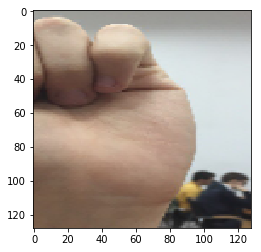

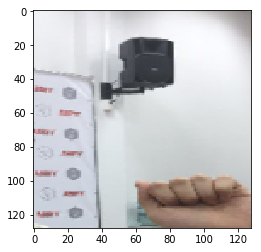

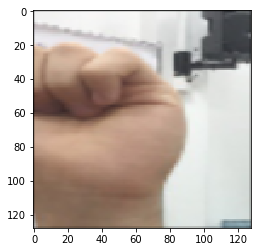

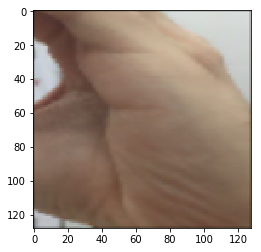

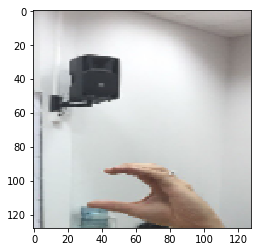

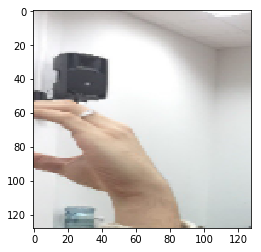

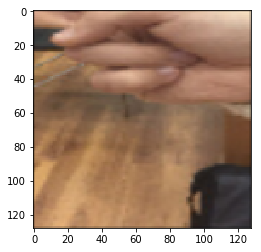

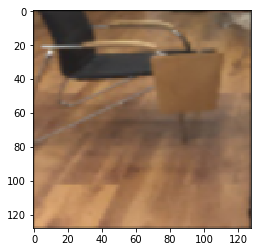

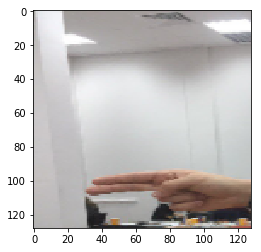

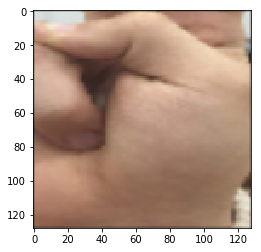

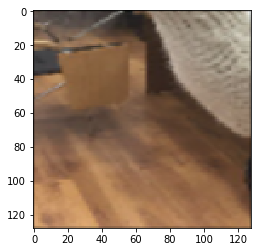

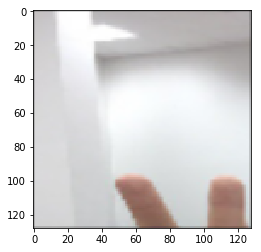

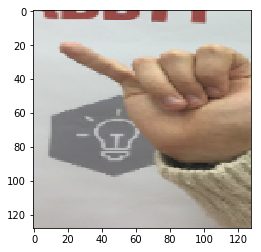

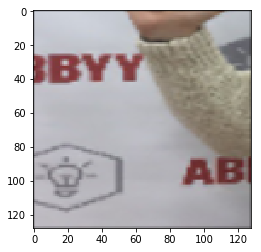

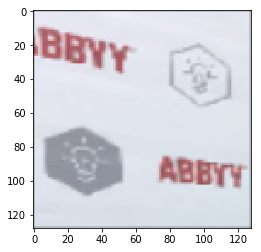

In [105]:
falsedata = []
for c in ['a', 'c', 'h', 'v', 'y']:
    for i in ['1', '2', '3']:
        crop_hand, hoggg = find_hand_on_picture(pca1, svm1, resize(plt.imread('../ilya/Our_hands/t' + c + i + '.jpg'), (320, 240, 3), mode='constant'))
        plt.imshow(crop_hand)
        plt.show()
        falsedata.append(crop_hand)

In [30]:
def read_draw(file):
    img = cv2.cvtColor(cv2.imread(file, cv2.IMREAD_COLOR), cv2.COLOR_BGR2RGB)
    #img = img.astype(np.uint8)
    img, hog = find_hand_on_picture(pca1, svm1, img)
    #img = cv2.resize(img, (128, 128))
    #plt.imshow(img)
    #print(type(img[0][0][0]))
    plt.imshow(clear_background_rough(img))

In [4]:
import pickle
#save classifier
def dumpclassifier(filename,model):
    with open(filename, 'wb') as fid:
        pickle.dump(model, fid) 
        
#load classifier
def loadClassifier(picklefile):
    fd = open(picklefile, 'rb')
    model = pickle.load(fd)
    fd.close()
    return model

In [5]:
pca_for_find_hand = loadClassifier('pca_is_hand.pickle') 
svm_for_find_hand = loadClassifier('svm_is_hand.pickle') 
pca_letter_classif = loadClassifier('pca_letter.pickle')
svm_letter_classif = loadClassifier('svm_letter.pickle')

In [6]:
import scipy
from scipy import ndimage
    
def process_image(filename):
    #image = ndimage.interpolation.rotate(image, 90) #Если хотим ещё перевернуть изображение
    image = cv2.imread(filename)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print(type(image[0][0][0]))
    cropped_image, hog = find_hand_on_picture(pca_for_find_hand, svm_for_find_hand, image)
    cropped_image = np.uint8(cropped_image)
    clrbackground = clear_background_precise(cropped_image)
    hog = convertToGrayToHOG(cropped_image)
    p = pca.transform(hog.reshape(1,-1))
    ans = svm.predict(p)
    return chr(ans[0] + ord('a'))

count = 0;
def dumpimages(X, Y, category):
    for i in range(X.shape[0]):
        cv2.imwrite('Merged/' + category + '/' + Y[i] + str(count) + '.png', X[i])

In [7]:
process_image('3.png')

NameError: name 'cv2' is not defined

In [156]:
ans

'c'